# Sprious Customer Analytics Case Study

## Dataset Description

Cancel Table:
1. userid - I've created fake userids and made them email addresses for this one.
2. orderid - Unique order # for a given purchase. One customer may have many orders.
3. customer_since - Date on which the customer first became a paying customer.
4. country - Home country of the customer.
5. amount - Order amount, which is typically monthly recurring revenue (MRR).
6. Client Status - Current state of customer account. There are three potential values:  Active, Inactive, and Closed.  The latter two are treated the same for this.
7. Order Status - Current state of order. 
8. billingcycle - Indicates whether this is monthly, quarterly, semi-annual, or annual payments.  As noted above on the Amount field, the vast majority of customers pay monthly.
9. product - We have a variety of product types, and I simply made this fake data by converting each to a numeric value. 
10. cancel_date - Self explanatory
11. Cancel Count (45 Days) - Count of an individual customer's orders that were cancelled in the last 45 days.
12. Active Order Count - Quantity of open orders for a single customer.
13. Recurring Amt - A summation of all active order $ amounts for a given customer. It is worth noting that this particular dataset may not have all orders for a customer, so if you sum up the values in the Amount field they are likely not going to total to the Recurring Amt field.
14. Customer Type - Indicates whether this customer ever actually paid us any money.  Many sign up for trials and then do not convert (which is one of the things I am hoping we can dive into deeper to understand why) and these are marked as 'Trial', whereas all those marked as 'Paying' either converted from trials or directly signed up and skipped the trial process.

Package Table:
1. Customer - This correlates to the customer ID in the Cancel table, although you would need to extract it from the email address.
2. Name - See note below. In short, this field has confused me for a while so you can likely disregard much of it. 
3. Category - We sell three types of proxies:  Dedicated (meaning a single customer has use), Semi-dedicated (meaning that multiple customers use the same one, but they get to pay a cheaper price as a result), and Rotating (meaning that they pay a set $ amount, and on a periodic basis that is usually around 10 minutes, they rotate amongst a pool of proxies).
4. Country - Our proxies IP addresses are in data centers throughout the world, so this is the location of that IP address.
5. Type - I'm actually not sure why this field sometimes has a combination of country and category, and usually just says standard.  I guess you're getting a flavor for some of the data quality issues I want to resolve.  :)  Recommend ignoring this field for now.
6. Category - Sorry, I should have labeled these better.  The first Category field above is from a proxy packages table, and this one in the far right column is from the history table. So for cancellations, this one is going to be the better to use.

# Data Profiling

In [45]:
# loading libraries
import pandas as pd
import numpy as np
import re

import pandasql
from pandasql import sqldf

import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.express as px
import plotly.graph_objects as go

from sklearn.cluster import KMeans

import pycountry

import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading cancel table
cancel_table = pd.read_excel("Sprious.xlsx", sheet_name = "Cancel Table for Case Study")
cancel_table.head()

,email,orderid,country_code,customer_since,amount,Client Status,Order Status,billingcycle,product,cancel_date,Cancel Count (45 Days),Active Order Count,Recurring Amt,Customer Type
0,dummy215842@sprious.com,112183,US,2018-08-14,71.5,Inactive,Cancelled,Monthly,Product 1,2019-07-22 00:16:09,NaN,0,0.0,Paying
1,dummy237318@sprious.com,129059,ES,2018-11-24,26.0,Inactive,Cancelled,Monthly,Product 2,2019-07-22 01:35:44,NaN,0,0.0,Paying
2,dummy264667@sprious.com,152715,US,2019-04-24,25.2,Inactive,Cancelled,Monthly,Product 3,2019-07-22 01:45:46,NaN,0,0.0,Paying
3,dummy255378@sprious.com,165297,BR,2019-02-28,3.0,Inactive,Cancelled,Monthly,Product 4,2019-07-22 06:05:02,NaN,0,0.0,Paying
4,dummy271219@sprious.com,157789,UA,2019-05-28,310.0,Inactive,Cancelled,Monthly,Product 5,2019-07-22 07:48:47,NaN,0,0.0,Paying


In [3]:
# loading package table
package_table = pd.read_excel("Sprious.xlsx", sheet_name = "Package Table for Case Study")
package_table.head()

,CustomerID,name,category,type,country,category.1
0,35200,10 Ports Monthly,rotate,de-rotate,de,rotate
1,47037,10 ports Monthly,static,us-static,us,static
2,51755,5 Port Proxy Plan,semi-3,us-semi-3,us,semi-3
3,55801,25 Ports Monthly,static,us-static,us,static
4,65531,10 ports Monthly,static,us-static,us,static


In [4]:
# cancel table info
cancel_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5733 entries, 0 to 5732
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   email                   5733 non-null   object        
 1   orderid                 5733 non-null   int64         
 2   country_code            5733 non-null   object        
 3   customer_since          5733 non-null   datetime64[ns]
 4   amount                  5733 non-null   float64       
 5   Client Status           5733 non-null   object        
 6   Order Status            5733 non-null   object        
 7   billingcycle            5733 non-null   object        
 8   product                 5733 non-null   object        
 9   cancel_date             5733 non-null   datetime64[ns]
 10  Cancel Count (45 Days)  998 non-null    float64       
 11  Active Order Count      5733 non-null   int64         
 12  Recurring Amt           5733 non-null   float64 

In [5]:
# package table info
package_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7569 entries, 0 to 7568
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerID  7569 non-null   int64 
 1   name        7569 non-null   object
 2   category    7569 non-null   object
 3   type        7569 non-null   object
 4   country     7569 non-null   object
 5   category.1  7569 non-null   object
dtypes: int64(1), object(5)
memory usage: 354.9+ KB


In [6]:
# checking null values in cancel table
cancel_table.isnull().sum()

email                        0
orderid                      0
country_code                 0
customer_since               0
amount                       0
Client Status                0
Order Status                 0
billingcycle                 0
product                      0
cancel_date                  0
Cancel Count (45 Days)    4735
Active Order Count           0
Recurring Amt                0
Customer Type                0
dtype: int64

In [7]:
# cheking null values in package table
package_table.isnull().sum()

CustomerID    0
name          0
category      0
type          0
country       0
category.1    0
dtype: int64

# Data Cleaning

### Cancel Table

In [9]:
# checking for duplicate rows
cancel_duplicates = cancel_table[cancel_table.duplicated()]
cancel_duplicates

,email,orderid,country_code,customer_since,amount,Client Status,Order Status,billingcycle,product,cancel_date,Cancel Count (45 Days),Active Order Count,Recurring Amt,Customer Type


In [8]:
# checking redundant data in orderid
order_duplicates = cancel_table.groupby("orderid").size().reset_index()
order_duplicates[order_duplicates[0] > 1]

,orderid,0
5227,222087,4


In [10]:
# checking the redundant orderid in the cancel_table
cancel_table[cancel_table["orderid"] == 222087]

,email,orderid,country_code,customer_since,amount,Client Status,Order Status,billingcycle,product,cancel_date,Cancel Count (45 Days),Active Order Count,Recurring Amt,Customer Type
4950,dummy236464@sprious.com,222087,AT,2018-11-20,200.0,Active,Cancelled,Monthly,Product 36,2020-06-08 05:26:48,5.0,3,3150.0,Paying
4951,dummy236464@sprious.com,222087,AT,2018-11-20,200.0,Active,Cancelled,Monthly,Product 36,2020-06-08 05:27:26,5.0,3,3150.0,Paying
4952,dummy236464@sprious.com,222087,AT,2018-11-20,200.0,Active,Cancelled,Monthly,Product 36,2020-06-08 05:27:42,5.0,3,3150.0,Paying
4953,dummy236464@sprious.com,222087,AT,2018-11-20,200.0,Active,Cancelled,Monthly,Product 36,2020-06-08 05:27:56,5.0,3,3150.0,Paying


In [11]:
# getting rid of the redundant rows
cancel_table = cancel_table.drop_duplicates(subset = "orderid", keep = "first")

In [12]:
# extracting userid from email
cancel_table["userid"] = cancel_table["email"].str.extract('(\d+)')
cancel_table.head()

,email,orderid,country_code,customer_since,amount,Client Status,Order Status,billingcycle,product,cancel_date,Cancel Count (45 Days),Active Order Count,Recurring Amt,Customer Type,userid
0,dummy215842@sprious.com,112183,US,2018-08-14,71.5,Inactive,Cancelled,Monthly,Product 1,2019-07-22 00:16:09,NaN,0,0.0,Paying,215842
1,dummy237318@sprious.com,129059,ES,2018-11-24,26.0,Inactive,Cancelled,Monthly,Product 2,2019-07-22 01:35:44,NaN,0,0.0,Paying,237318
2,dummy264667@sprious.com,152715,US,2019-04-24,25.2,Inactive,Cancelled,Monthly,Product 3,2019-07-22 01:45:46,NaN,0,0.0,Paying,264667
3,dummy255378@sprious.com,165297,BR,2019-02-28,3.0,Inactive,Cancelled,Monthly,Product 4,2019-07-22 06:05:02,NaN,0,0.0,Paying,255378
4,dummy271219@sprious.com,157789,UA,2019-05-28,310.0,Inactive,Cancelled,Monthly,Product 5,2019-07-22 07:48:47,NaN,0,0.0,Paying,271219


In [13]:
# converting from datetime to date
cancel_table["cancel_date"] = cancel_table["cancel_date"].dt.date
cancel_table["cancel_date"] = pd.to_datetime(cancel_table["cancel_date"])
cancel_table.head()

,email,orderid,country_code,customer_since,amount,Client Status,Order Status,billingcycle,product,cancel_date,Cancel Count (45 Days),Active Order Count,Recurring Amt,Customer Type,userid
0,dummy215842@sprious.com,112183,US,2018-08-14,71.5,Inactive,Cancelled,Monthly,Product 1,2019-07-22,NaN,0,0.0,Paying,215842
1,dummy237318@sprious.com,129059,ES,2018-11-24,26.0,Inactive,Cancelled,Monthly,Product 2,2019-07-22,NaN,0,0.0,Paying,237318
2,dummy264667@sprious.com,152715,US,2019-04-24,25.2,Inactive,Cancelled,Monthly,Product 3,2019-07-22,NaN,0,0.0,Paying,264667
3,dummy255378@sprious.com,165297,BR,2019-02-28,3.0,Inactive,Cancelled,Monthly,Product 4,2019-07-22,NaN,0,0.0,Paying,255378
4,dummy271219@sprious.com,157789,UA,2019-05-28,310.0,Inactive,Cancelled,Monthly,Product 5,2019-07-22,NaN,0,0.0,Paying,271219


In [14]:
# obtaining the period of the customer's stay with the company
cancel_table["period"] = cancel_table["cancel_date"] - cancel_table["customer_since"]
cancel_table["period"] = cancel_table["period"] / np.timedelta64(1, 'D')
cancel_table["period"].head()

0    342.0
1    240.0
2     89.0
3    144.0
4     55.0
Name: period, dtype: float64

In [15]:
# checking for different values within order status
cancel_table["Order Status"].value_counts()

Cancelled     5292
Terminated     240
Active         196
Fraud            1
Pending          1
Name: Order Status, dtype: int64

In [16]:
# getting rid of pending and fraud type due to the shortage of data to be considered significant
cancel_table = cancel_table[(cancel_table["Order Status"] != "Pending") & (cancel_table["Order Status"] != "Fraud")]
cancel_table["Order Status"].value_counts()

Cancelled     5292
Terminated     240
Active         196
Name: Order Status, dtype: int64

#### Assumption 1:
Assuming Terminated and Cancelled status to be the same sicne not enough context on dataset to consider them seperately 

In [17]:
# generalizing cancelled and terminated status of the order (Assumption - 1)
def terminated_to_cancelled(value):
    if value == "Terminated":
        new_value = "Cancelled"
    else:
        new_value = value
    
    return new_value

cancel_table["Order Status"] = cancel_table["Order Status"].apply(terminated_to_cancelled)
cancel_table["Order Status"].value_counts()

Cancelled    5532
Active        196
Name: Order Status, dtype: int64

In [18]:
# checking for different values within client status
cancel_table["Client Status"].value_counts()

Inactive    4619
Active      1062
Closed        47
Name: Client Status, dtype: int64

#### Assumption 2:
Assuming Closed and Inactive status to be the same sicne not enough context on dataset to consider them seperately 

In [19]:
# generalizing closed and inactive status of the client (Assumption - 2)
def closed_to_inactive(value):
    if value == "Closed":
        new_value = "Inactive"
    else:
        new_value = value
    
    return new_value

cancel_table["Client Status"] = cancel_table["Client Status"].apply(closed_to_inactive)
cancel_table["Client Status"].value_counts()

Inactive    4666
Active      1062
Name: Client Status, dtype: int64

In [20]:
# obtaining country name from country code
def code_to_country(value):
    country = pycountry.countries.get(alpha_2 = value)
    name = country.name
    
    return name 

cancel_table["country"] = cancel_table["country_code"].apply(code_to_country)

### Package Table

In [21]:
# checking for duplicate rows
package_duplicates = package_table[package_table.duplicated()]
package_duplicates

,CustomerID,name,category,type,country,category.1
715,193421,No Plan Selected,rotate,standard,us,static
738,200421,No Plan Selected,rotate,standard,br,static
742,214729,No Plan Selected,rotate,standard,de,static
753,201261,No Plan Selected,rotate,standard,us,static
759,134502,No Plan Selected,rotate,standard,us,rotate
...,...,...,...,...,...,...
7491,331797,No Plan Selected,rotate,standard,ca,static
7492,331797,No Plan Selected,rotate,standard,gb,static
7514,48346,No Plan Selected,rotate,standard,us,static
7553,273410,No Plan Selected,rotate,standard,us,static


In [22]:
# dropping duplicate rows
package_table = package_table.drop_duplicates()

In [23]:
# renaming the redundant category columns
package_table.rename(columns = {"category": "proxy_category", "category.1": "history_category"}, inplace = True)
package_table.head()

,CustomerID,name,proxy_category,type,country,history_category
0,35200,10 Ports Monthly,rotate,de-rotate,de,rotate
1,47037,10 ports Monthly,static,us-static,us,static
2,51755,5 Port Proxy Plan,semi-3,us-semi-3,us,semi-3
3,55801,25 Ports Monthly,static,us-static,us,static
4,65531,10 ports Monthly,static,us-static,us,static


In [24]:
# getting rid of wrong naming of the name columns
def renaming_names(value):
    if value == "10 ports Monthly":
        new_value = "10 Ports Monthly"
    elif value == "5 Port Proxy Plan":
        new_value = "5 Ports Monthly"
    elif value == "No Plan Selected":
        new_value = "Default"
    else:
        new_value = value
    
    new_value = re.sub(r"\s+", "_", new_value)
    
    return new_value

package_table["name"] = package_table["name"].apply(renaming_names)
package_table["name"].value_counts()

Default               6105
10_Ports_Monthly         6
5_Ports_Monthly          6
25_Ports_Monthly         4
50_Ports_Monthly         4
1000_Ports_Monthly       1
100_Ports_Monthly        1
Name: name, dtype: int64

In [99]:
# obtaining country name from country code
def code_to_country(value):
    country = pycountry.countries.get(alpha_2 = value)
    name = country.name
    
    return name 

package_table["country_name"] = package_table["country"].apply(code_to_country)

# Exploratory Data Analysis

## Cacnellation Table
## 1. Is there an yearly increase in the number of new customers and orders?

In [31]:
# overlapping graph for orders and customers over years
grouped = cancel_table.groupby("userid")["customer_since"].min().reset_index()
grouped["start_year"] = grouped["customer_since"].dt.year
customer_grouped = grouped.groupby("start_year")["userid"].count().reset_index()

grouped = cancel_table.copy()
grouped["start_year"] = grouped["customer_since"].dt.year
year_grouped = grouped.groupby("start_year")["orderid"].count().reset_index()

trace1 = go.Scatter(
    x = year_grouped["start_year"],
    y = year_grouped["orderid"],
    name = "orders"
)

trace2 = go.Bar(
    x = customer_grouped["start_year"],
    y = customer_grouped["userid"],
    name = "customers"
    
)

data = [trace1, trace2]
fig = go.Figure(data = data)
fig.show()

### Interpretation
1. It can be seen that the number of orders is increasing with the number of customers over the years.
2. This indicates positive growth in the company.
3. The number of orders and customers for the year 2020 in the visualization can be ignored for now since we do not have the entire data for 2020 yet.

## Where are our customer coming from?

In [32]:
# geo map for customers from different countries
import plotly.express as px

df = cancel_table.groupby("country")["userid"].nunique().reset_index()
fig = px.choropleth(df, locations="country",
                    color="userid", 
                    locationmode = "country names",
                    color_continuous_scale=px.colors.sequential.Plasma
                   )
fig.show()

In [33]:
# setting up the data to plot a pie chart
df.sort_values("userid", inplace = True, ascending = False)
pull = [0.1]
for i in range(109):
    pull.append(0)
    
fig = go.Figure(data=[go.Pie(labels=df["country"], values=df["userid"],
                             pull = pull
                            )])
fig.show()

#### Interpretation
1. 34.8% of our entire customer base is from the United States.
2. This would most likely lead to United States producing most number of orders as well.
3. This can be seen in the following visualizaton.

## Where are our orders coming from?

In [34]:
# checking where our main source of orders is from
df = cancel_table.groupby("country")["orderid"].count().reset_index()
fig = px.choropleth(df, locations="country",
                    color="orderid", # lifeExp is a column of gapminder
                    locationmode = "country names",
                    color_continuous_scale=px.colors.sequential.Plasma
                   )
fig.show()

In [35]:
# setting up the data to plot a pie chart
df.sort_values("orderid", inplace = True, ascending = False)
pull = [0.1]
for i in range(109):
    pull.append(0)
    
fig = go.Figure(data=[go.Pie(labels=df["country"], values=df["orderid"],
                             pull = pull
                            )])
fig.show()

#### Interpretation
1. As expected, United States contributes to 33.3% of the entire orders received.
2. This visualization only shows the orders received.
3. We need to check if the clients making the orders are retained.
4. This can bee seen in the following visualization below.

## What is the Churn Rate of our most popular customer base?

In [40]:
# Comparing us and other countries
df = cancel_table.copy()

def us_or_not(value):
    if value == "US":
        new_value = 1
    else:
        new_value = 0
    
    return new_value

df["US"] = df["country_code"].apply(us_or_not) 

# churn rate for us and non-us customers
grouped = df.groupby(["US", "userid"])
sub_grouped = pd.DataFrame()
for name, group in grouped:
    group.sort_values("cancel_date", inplace = True, ascending = False)
    new = group[["US", "userid", "country", "Client Status"]].head(1)
    sub_grouped = sub_grouped.append(new, ignore_index = True)
    
new_grouped = sub_grouped.groupby("US")
churn = pd.DataFrame(columns = ["country", "rate"])
for name, group in new_grouped:
    if name == 1:
        country = "US"
    else:
        country = "Non-US"
        
    churn_rate = len(group[group["Client Status"] == "Inactive"]) / len(group)
    churn = churn.append({"country": country,
                          "rate": churn_rate}, ignore_index=True)

fig = px.bar(churn, x = "country", y = "rate", color = "country")
fig.show()

C:\Users\manis\AppData\Local\Continuum\anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Interpreation
1. The churn rate of customers from United States is higher than the combined curn rate of the customers from remaining countries.
2. This is very bad since we are losing customers from our most popular customer base.
3. We need to build a strategy to retain these customers.
4. This could be done on further analysis of the products that customers are ordering.


## What are our top 10 products?

In [41]:
# identifying top 10 prodcuts ordered
df = cancel_table.copy()
grouped = df.groupby("product")["orderid"].count().reset_index()
grouped.sort_values("orderid", ascending = False, inplace = True)
grouped = grouped.iloc[0:10, :]

fig = px.bar(grouped, x = "product", y = "orderid")
fig.show()

## Are we doing well in retaining customer interest in the top 10 products?

In [43]:
# dataframe defining overall statistics of each product type
df = cancel_table.copy()
grouped = df.groupby("product")
new_df = pd.DataFrame(columns = ["Product", "Total_Count", "Active_Count", "Cancelled_Count", "Churn_Rate", "Retention_Rate"])
for name, group in grouped:
    total_count = len(group)
    active_count = len(group[group["Order Status"] == "Active"])
    cancelled_count = len(group[group["Order Status"] == "Cancelled"])
    churn_rate = cancelled_count/total_count
    retention_rate = active_count/total_count
    new_df = new_df.append({"Product": name,
                            "Total_Count": total_count,
                            "Active_Count": active_count,
                            "Cancelled_Count": cancelled_count,
                            "Churn_Rate": churn_rate,
                            "Retention_Rate": retention_rate}, ignore_index = True)

new_df.sort_values("Total_Count", ascending = False, inplace = True)
new_df = new_df.iloc[:10, :]

trace1 = go.Bar(
    x = new_df["Product"],
    y = new_df["Total_Count"],
    name = "Total Orders"
)
trace2 = go.Bar(
    x = new_df["Product"],
    y = new_df["Cancelled_Count"],
    name = "Cancelled"
)

trace3 = go.Bar(
    x = new_df["Product"],
    y = new_df["Active_Count"]
)

data = [trace1, trace2, trace3]
fig = go.Figure(data = data)
fig.show()

#### Interpretation
1. The ratio of active to cancelled orders is very less.
2. This shows that, eventhough we are getting new customers and orders, the problem we are facing is very low retention rate.
3. This is something that would need immediate attention a small increase in retention rate can lead to huge increase in revenue.

## Package Table

## What is the most popular proxy category chosen by customers?

In [97]:
# pie chart for category
data = package_table.copy()
df = data.groupby("history_category")["CustomerID"].count().reset_index()
df.sort_values("CustomerID", ascending = False, inplace = True)
pull = [0.1, 0, 0, 0, 0, 0, 0]
fig = go.Figure(data=[go.Pie(labels=df["history_category"], values=df["CustomerID"],
                             pull = pull
                            )])
fig.show()

#### Interpretation
1. Static dominates the proxy category chosen by customers with a wooping contribution of 62.7%.
2. Semi-3 and rotate are chosen moderately while the are other categories are rarely chosen.

## Which data centers are being used the most?

In [100]:
# geo map for data centers
import plotly.express as px

df = package_table.groupby("country_name")["CustomerID"].count().reset_index()
fig = px.choropleth(df, locations="country_name",
                    color="CustomerID",
                    locationmode = "country names",
                    color_continuous_scale=px.colors.sequential.Plasma
                   )
fig.show()

In [101]:
data = package_table.copy()
df = data.groupby("country_name")["CustomerID"].count().reset_index()
df.sort_values("CustomerID", ascending = False, inplace = True)
pull = [0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
fig = go.Figure(data=[go.Pie(labels=df["country_name"], values=df["CustomerID"],
                             pull = pull
                            )])
fig.show()

#### Interpretation
1. Most of our data centers are located in the United States.
2. This is most likely because of the high number of customers and orders in the region.

## Which is the most popular package?

In [102]:
data = package_table.copy()
df = data.groupby("name")["CustomerID"].count().reset_index()
fig = go.Figure(data=[go.Pie(labels=df["name"], values=df["CustomerID"],
                            )])
fig.show()

#### Interpretation
1. Default package seems to be the one that is mostly chosen for the orders made by customers.
2. This might be due to high quality, low cost, good service rate of the package but cannot be particulary specified now due to lack of context on the data.

# Customer Segmentation

In [47]:
# defining function to get overall revenue for an order
def revenue(df):
    if df["billingcycle"] == "Monthly":
        value = df["amount"] * 12
    elif df["billingcycle"] == "Quarterly":
        value = df["amount"] * 4
    elif df["billingcycle"] == "Semi-Annually":
        value = df["amount"] * 2
    else:
        value = df["amount"]
    
    return value

# obtaing the dataframe determining the tenure, no. of orders and revenue of each customer
df = cancel_table.copy()
df["revenue"] = df.apply(revenue, axis=1)
grouped = df.groupby("userid")
new_df = pd.DataFrame(columns = ["userid", "tenure", "orders", "revenue"])
for name, group in grouped:
    revenue = group["revenue"].sum()
    tenure = group["period"].sum()
    orders = group["orderid"].count()
    new_df = new_df.append({"userid": name,
                            "tenure": tenure,
                            "orders": orders,
                            "revenue": revenue}, ignore_index = True)

new_df.head()

,userid,tenure,orders,revenue
0,101567,1167.0,1,72.00
1,105928,1215.0,1,270.00
2,106684,975.0,1,288.00
3,107013,2307.0,2,280.08
4,107468,1152.0,1,72.00


### Tenure

In [48]:
# histogram for tenure distribution
plot_data = [
    go.Histogram(
        x=new_df['tenure']
    )
]

plot_layout = go.Layout(
        title='Tenure'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

In [49]:
# removing outliers for better visual representation
new_df1 = new_df[new_df["tenure"] <= 4000]

In [50]:
# histogram for tenure distribution
plot_data = [
    go.Histogram(
        x=new_df1['tenure']
    )
]

plot_layout = go.Layout(
        title='Tenure'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

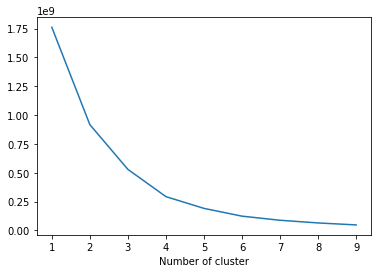

In [51]:
# creating elbow plot to decide on right number of clusters
sse={}
tenure = new_df[['tenure']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tenure)
    tenure["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

#### Interpretation
1. The right number of clusters is somewhere in the range of 4 to 6

In [52]:
# using k-means to assign clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(new_df[['tenure']])
new_df['TenureCluster'] = kmeans.predict(new_df[['tenure']])

In [53]:
# describing cluster info
new_df.groupby("TenureCluster")["tenure"].describe()

,count,mean,std,min,25%,50%,75%,max
TenureCluster,,,,,,,,
0,3652.0,102.919770,130.325112,0.0,3.00,37.0,154.0,505.0
1,101.0,2740.752475,1084.606642,1830.0,2044.00,2307.0,2996.0,7298.0
2,2.0,15080.000000,5902.927409,10906.0,12993.00,15080.0,17167.0,19254.0
3,778.0,909.771208,317.130907,506.0,646.25,831.5,1097.0,1789.0


In [54]:
# defining a function to order the cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [56]:
# ordering the cluster numbers
new_df = order_cluster('TenureCluster', "tenure", new_df, False)
new_df.groupby("TenureCluster")["tenure"].describe()

,count,mean,std,min,25%,50%,75%,max
TenureCluster,,,,,,,,
0,2.0,15080.000000,5902.927409,10906.0,12993.00,15080.0,17167.0,19254.0
1,101.0,2740.752475,1084.606642,1830.0,2044.00,2307.0,2996.0,7298.0
2,778.0,909.771208,317.130907,506.0,646.25,831.5,1097.0,1789.0
3,3652.0,102.919770,130.325112,0.0,3.00,37.0,154.0,505.0


### Number of Orders

In [63]:
# converting ddata type of orders
new_df["orders"] = new_df["orders"].astype(int)

# histogram for orders distribution
plot_data = [
    go.Histogram(
        x=new_df['orders']
    )
]

plot_layout = go.Layout(
        title='Orders'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

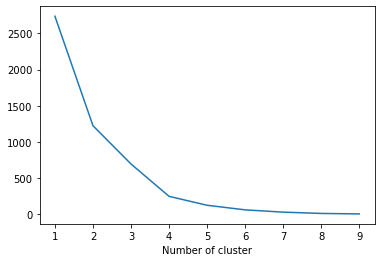

In [64]:
# creating elbow plot to decide on right number of clusters
sse={}
orders = new_df[['orders']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(orders)
    orders["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

#### Interpretation
1. The right number of clusters is somewhere in the range of 4 to 6

In [65]:
# using k-means to assign clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(new_df[['orders']])
new_df['OrderCluster'] = kmeans.predict(new_df[['orders']])

In [66]:
# describing cluster info
new_df.groupby("OrderCluster")["orders"].describe()

,count,mean,std,min,25%,50%,75%,max
OrderCluster,,,,,,,,
0,3739.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0
1,78.0,4.923077,1.235505,4.0,4.0,4.0,5.75,9.0
2,714.0,2.197479,0.398376,2.0,2.0,2.0,2.00,3.0
3,2.0,18.000000,4.242641,15.0,16.5,18.0,19.50,21.0


In [68]:
# ordering the cluster numbers
new_df = order_cluster('OrderCluster', 'orders', new_df, False)
new_df.groupby("OrderCluster")["orders"].describe()

,count,mean,std,min,25%,50%,75%,max
OrderCluster,,,,,,,,
0,2.0,18.000000,4.242641,15.0,16.5,18.0,19.50,21.0
1,78.0,4.923077,1.235505,4.0,4.0,4.0,5.75,9.0
2,714.0,2.197479,0.398376,2.0,2.0,2.0,2.00,3.0
3,3739.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0


### Revenue

In [69]:
# histogram for revenue distribution
plot_data = [
    go.Histogram(
        x=new_df['revenue']
    )
]

plot_layout = go.Layout(
        title='Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

In [74]:
# removing outliers for better visual representation
new_df1 = new_df[new_df["revenue"] <= float(10000)]

# histogram for revenue distribution
plot_data = [
    go.Histogram(
        x=new_df1['revenue']
    )
]

plot_layout = go.Layout(
        title='Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

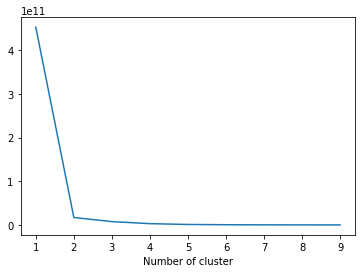

In [75]:
# creating elbow plot to decide on right number of clusters
sse={}
revenue = new_df[['revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(revenue)
    revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

#### Interpretation
1. The right number of clusters is somewhere in the range of 3 to 5

In [76]:
# using k-means to assign clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(new_df[['revenue']])
new_df['RevenueCluster'] = kmeans.predict(new_df[['revenue']])

In [77]:
# describing cluster info
new_df.groupby("RevenueCluster")["revenue"].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,4531.0,398.643099,1311.74576,0.0,72.0,132.0,276.0,32400.0
1,1.0,660000.000000,NaN,660000.0,660000.0,660000.0,660000.0,660000.0
2,1.0,97449.600000,NaN,97449.6,97449.6,97449.6,97449.6,97449.6


In [78]:
# ordering cluster numbers
new_df = order_cluster('RevenueCluster', 'revenue', new_df, False)
new_df.groupby("RevenueCluster")["revenue"].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,1.0,660000.000000,NaN,660000.0,660000.0,660000.0,660000.0,660000.0
1,1.0,97449.600000,NaN,97449.6,97449.6,97449.6,97449.6,97449.6
2,4531.0,398.643099,1311.74576,0.0,72.0,132.0,276.0,32400.0


#### Interpretation
1. As you can see, there are only one customer each in the top two clusters.
2. This bias is caused only because of data insufficiency in terms of revenue clusters.
3. To avoid further bias in overall score, I have taken 5 clusters to disperse the customers more.

In [79]:
# using k-means to assign clusters
kmeans = KMeans(n_clusters=5)
kmeans.fit(new_df[['revenue']])
new_df['RevenueCluster'] = kmeans.predict(new_df[['revenue']])

In [80]:
# describing cluster info
new_df.groupby("RevenueCluster")["revenue"].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,4447.0,265.872121,396.689576,0.00,72.00,120.00,257.1,2952.0
1,1.0,660000.000000,NaN,660000.00,660000.00,660000.00,660000.0,660000.0
2,1.0,97449.600000,NaN,97449.60,97449.60,97449.60,97449.6,97449.6
3,8.0,23582.100000,4760.871312,15096.96,22050.00,24006.12,24471.9,32400.0
4,76.0,5727.128421,2310.405215,3104.40,3764.13,4800.00,7200.0,12000.0


In [81]:
# ordering cluster numbers
new_df = order_cluster('RevenueCluster', 'revenue', new_df, False)
new_df.groupby("RevenueCluster")["revenue"].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,1.0,660000.000000,NaN,660000.00,660000.00,660000.00,660000.0,660000.0
1,1.0,97449.600000,NaN,97449.60,97449.60,97449.60,97449.6,97449.6
2,8.0,23582.100000,4760.871312,15096.96,22050.00,24006.12,24471.9,32400.0
3,76.0,5727.128421,2310.405215,3104.40,3764.13,4800.00,7200.0,12000.0
4,4447.0,265.872121,396.689576,0.00,72.00,120.00,257.1,2952.0


In [82]:
# displaying data with all clusters assigned
new_df.head()

,userid,tenure,orders,revenue,TenureCluster,OrderCluster,RevenueCluster
0,101567,1167.0,1,72.0,2,3,4
1,105928,1215.0,1,270.0,2,3,4
2,106684,975.0,1,288.0,2,3,4
3,107468,1152.0,1,72.0,2,3,4
4,108819,868.0,1,696.0,2,3,4


### Overall Score

In [83]:
# calculating overall score
new_df['OverallScore'] = new_df['TenureCluster'] + new_df['OrderCluster'] + new_df['RevenueCluster']
new_df.groupby('OverallScore')['tenure','orders','revenue'].mean().reset_index()

,OverallScore,tenure,orders,revenue
0,3,15080.000000,15.000000,15578.280000
1,4,3398.500000,10.000000,20087.280000
2,5,2619.400000,4.400000,81565.104000
3,6,2804.828571,4.714286,3376.486857
4,7,2017.161290,2.752688,1764.535484
5,8,901.673171,2.404878,1244.002537
6,9,523.168561,1.505682,487.328409
7,10,97.257508,1.000000,199.616984


#### Interpretation
1. Right now I have taken equal weights of all clusters and calculated this score. 
2. But ideally, it would be better to take a weighted estimate of each cluster (such as more importance to revenue or orders or tenure depending on what we're looking to improve). 
3. The scoring here might be affected due to insufficiency of data which is causing irregualr clusters in terms of revenue.

In [88]:
# defining a function to assign clusters
def segments(score):
    if score in range(3, 7):
        segment = "High Value Customers"
    elif score in range(7, 9):
        segment = "Mid Value Customers"
    else:
        segment = "Low Value Customers"
    
    return segment

new_df["Segment"] = new_df["OverallScore"].apply(segments)
new_df.head()

,userid,tenure,orders,revenue,TenureCluster,OrderCluster,RevenueCluster,OverallScore,Segment
0,101567,1167.0,1,72.0,2,3,4,9,Low Value Customers
1,105928,1215.0,1,270.0,2,3,4,9,Low Value Customers
2,106684,975.0,1,288.0,2,3,4,9,Low Value Customers
3,107468,1152.0,1,72.0,2,3,4,9,Low Value Customers
4,108819,868.0,1,696.0,2,3,4,9,Low Value Customers


In [89]:
# viewing customer counts of different segments.
new_df["Segment"].value_counts()

Low Value Customers     4186
Mid Value Customers      298
High Value Customers      49
Name: Segment, dtype: int64

In [93]:
# ignoring outliers(very high values) for clearer visualizaton of segments
new_df = new_df.query("revenue < 80000 and tenure < 10000")

# plotting customer segments for revenue vs tenure
plot_data = [
    go.Scatter(
        x=new_df.query("Segment == 'Low Value Customers'")['tenure'],
        y=new_df.query("Segment == 'Low Value Customers'")['revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=new_df.query("Segment == 'Mid Value Customers'")['tenure'],
        y=new_df.query("Segment == 'Mid Value Customers'")['revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=new_df.query("Segment == 'High Value Customers'")['tenure'],
        y=new_df.query("Segment == 'High Value Customers'")['revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Tenure"},
        title='Customer Segments - Revenue VS Tenure',
        autosize=False, width=800, height=700
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

In [94]:
# plotting customer segments for revenue vs order
plot_data = [
    go.Scatter(
        x=new_df.query("Segment == 'Low Value Customers'")['orders'],
        y=new_df.query("Segment == 'Low Value Customers'")['revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=new_df.query("Segment == 'Mid Value Customers'")['orders'],
        y=new_df.query("Segment == 'Mid Value Customers'")['revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=new_df.query("Segment == 'High Value Customers'")['orders'],
        y=new_df.query("Segment == 'High Value Customers'")['revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Orders"},
        title='Customer Segments - Revenue VS Orders',
        autosize=False, width=800, height=700
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

In [96]:
# plotting customer segments for orders vs tenure
plot_data = [
    go.Scatter(
        x=new_df.query("Segment == 'Low Value Customers'")['orders'],
        y=new_df.query("Segment == 'Low Value Customers'")['tenure'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=new_df.query("Segment == 'Mid Value Customers'")['orders'],
        y=new_df.query("Segment == 'Mid Value Customers'")['tenure'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=new_df.query("Segment == 'High Value Customers'")['orders'],
        y=new_df.query("Segment == 'High Value Customers'")['tenure'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Tenure"},
        xaxis= {'title': "Orders"},
        title='Customer Segments - Tenure VS Orders',
        autosize=False, width=800, height=700
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
fig.show()

# Future Work

##### 1. Conversion rate from trial to paying
1. Right now, I tried performing the conversion rate but only found one order converted.
2. With better and more accurate data, we can determine which products have a high conversion rate as this is a very important to consider in terms of product analysis.


In [110]:
# attempt to find conversion rate
df = cancel_table.copy()
grouped = df.groupby(["userid", "product"])
conversion = pd.DataFrame(columns = ["userid", "product", "status"])
for name, group in grouped:
    group.sort_values("customer_since", inplace = True)
    orders = group["orderid"].count()
    if orders > 1:
        if group["Customer Type"].nunique() > 1:
            type_list = list(group["Customer Type"])
            conv_list = []
            for i in range(len(type_list) - 1):
                if type_list[i] == "Paying" and type_list[i + 1] == "Trial":
                    status = "converted"
                    conv_list.append("converted")
                else:
                    conv_list.append("non-converted")
                    
            if conv_list.count("converted") >=1:
                conversion = conversion.append({"userid": group.iloc[0]["userid"],
                                                    "product": group.iloc[0]["product"],
                                                    "status": status}, ignore_index = True)
                
                
conversion

,userid,product,status
0,92572,Product 9,converted


##### 2. Joining the cancel and package table to find more relations
1. I joined the cancel and package table to find any relations.
2. Tried to see if no. of orders from cancel table matches with number of packages from package table.
3. There could be a better analysis of this if I were given a more detailed understanding of the products and packages at Sprious.

In [117]:
# function for overall revenue
def revenue(df):
    if df["billingcycle"] == "Monthly":
        value = df["amount"] * 12
    elif df["billingcycle"] == "Quarterly":
        value = df["amount"] * 4
    elif df["billingcycle"] == "Semi-Annually":
        value = df["amount"] * 2
    else:
        value = df["amount"]
    
    return value
# organizing dataset for joining
df = cancel_table.copy()
df["revenue"] = df.apply(revenue, axis=1)
# df = pd.get_dummies(df, columns = ["product"])
grouped = df.groupby("userid")
final_data = pd.DataFrame(columns = ["userid", "country_code", "orders", "revenue", "tenure", "client_status", "product"])
for name, group in grouped:
    country_code = group.iloc[0]["country_code"]
    orders = group["orderid"].count()
    revenue = group["revenue"].sum()
    tenure = group["period"].sum()
    product = group["product"].nunique()
    group.sort_values("cancel_date", ascending = False, inplace = True)
    client_status = group.iloc[0]["Client Status"]
    final_data = final_data.append({"userid": name,
                                    "country_code": country_code,
                                    "orders": orders,
                                    "revenue": revenue,
                                    "tenure": tenure,
                                    "client_status": client_status,
                                    "product": product}, ignore_index = True)
    
final_data.head()

,userid,country_code,orders,revenue,tenure,client_status,product
0,101567,PT,1,72.00,1167.0,Inactive,1
1,105928,US,1,270.00,1215.0,Inactive,1
2,106684,US,1,288.00,975.0,Inactive,1
3,107013,ES,2,280.08,2307.0,Inactive,2
4,107468,IT,1,72.00,1152.0,Inactive,1


In [118]:
# organizing package table for joining
df = pd.get_dummies(package_table, columns = ["name", "history_category"])
df.rename(columns = {"history_category_semi-3" : "history_category_semi"}, inplace = True)
df.head()

,CustomerID,proxy_category,type,country,country_name,name_1000_Ports_Monthly,name_100_Ports_Monthly,name_10_Ports_Monthly,name_25_Ports_Monthly,name_50_Ports_Monthly,name_5_Ports_Monthly,name_Default,history_category_block,history_category_mobile,history_category_rotate,history_category_semi,history_category_shopify,history_category_sneaker,history_category_static
0,35200,rotate,de-rotate,de,Germany,0,0,1,0,0,0,0,0,0,1,0,0,0,0
1,47037,static,us-static,us,United States,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,51755,semi-3,us-semi-3,us,United States,0,0,0,0,0,1,0,0,0,0,1,0,0,0
3,55801,static,us-static,us,United States,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,65531,static,us-static,us,United States,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [114]:
# reducing the package table
q = """
SELECT CustomerID, SUM(history_category_block),
       SUM(history_category_mobile), SUM(history_category_rotate),
       SUM(history_category_semi), SUM(history_category_shopify),
       SUM(history_category_sneaker), SUM(history_category_static),
       SUM(name_10_Ports_Monthly), SUM(name_100_Ports_Monthly),
       SUM(name_1000_Ports_Monthly), SUM(name_25_Ports_Monthly),
       SUM(name_5_Ports_Monthly), SUM(name_50_Ports_Monthly),
       SUM(name_Default)
FROM df
GROUP BY CustomerID
"""

result = sqldf(q, globals())
result.head()

,CustomerID,SUM(history_category_block),SUM(history_category_mobile),SUM(history_category_rotate),SUM(history_category_semi),SUM(history_category_shopify),SUM(history_category_sneaker),SUM(history_category_static),SUM(name_10_Ports_Monthly),SUM(name_100_Ports_Monthly),SUM(name_1000_Ports_Monthly),SUM(name_25_Ports_Monthly),SUM(name_5_Ports_Monthly),SUM(name_50_Ports_Monthly),SUM(name_Default)
0,1320,0,0,0,1,0,0,1,0,0,0,0,0,0,2
1,1432,0,0,1,0,0,0,1,0,0,0,0,0,0,2
2,2125,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,3203,0,0,0,1,0,0,1,0,0,0,0,0,0,2
4,4099,0,0,2,1,0,0,3,0,0,0,0,0,0,6


In [115]:
# calculating total packages
result["packages"] = result["SUM(name_10_Ports_Monthly)"] + result["SUM(name_100_Ports_Monthly)"] \
                    + result["SUM(name_1000_Ports_Monthly)"] + result["SUM(name_25_Ports_Monthly)"] \
                    + result["SUM(name_5_Ports_Monthly)"] + result["SUM(name_50_Ports_Monthly)"] \
                    + result["SUM(name_Default)"]

result.head()  

,CustomerID,SUM(history_category_block),SUM(history_category_mobile),SUM(history_category_rotate),SUM(history_category_semi),SUM(history_category_shopify),SUM(history_category_sneaker),SUM(history_category_static),SUM(name_10_Ports_Monthly),SUM(name_100_Ports_Monthly),SUM(name_1000_Ports_Monthly),SUM(name_25_Ports_Monthly),SUM(name_5_Ports_Monthly),SUM(name_50_Ports_Monthly),SUM(name_Default),packages
0,1320,0,0,0,1,0,0,1,0,0,0,0,0,0,2,2
1,1432,0,0,1,0,0,0,1,0,0,0,0,0,0,2,2
2,2125,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1
3,3203,0,0,0,1,0,0,1,0,0,0,0,0,0,2,2
4,4099,0,0,2,1,0,0,3,0,0,0,0,0,0,6,6


In [120]:
# joining two tables
q = """
SELECT fd.userid, fd.orders, fd.product, rd.packages
FROM final_data as fd
INNER JOIN result as rd
ON fd.userid = rd.CustomerID
"""

joined = sqldf(q, globals())
joined.head()

,userid,orders,product,packages
0,101567,1,1,1
1,105928,1,1,1
2,106684,1,1,1
3,107013,2,2,2
4,107468,1,1,1


In [121]:
# list containing matches
match = list(joined["product"] == joined["packages"])
print(len(match))
print(match.count(True))

4098
3300


##### 3. Churn Prediction
1. Right now, I have considered the limited infomration about customers and products to build a churn prediction model.
2. The model and it's accuracy can be seen in the file named Churn_Prediction.
3. With better understanding of the data and holding discussions on what feautre matters more, we cna build a better churn precition model.